In [1]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from discharge_model import Predictor
from preprocessing import *
from utils import *

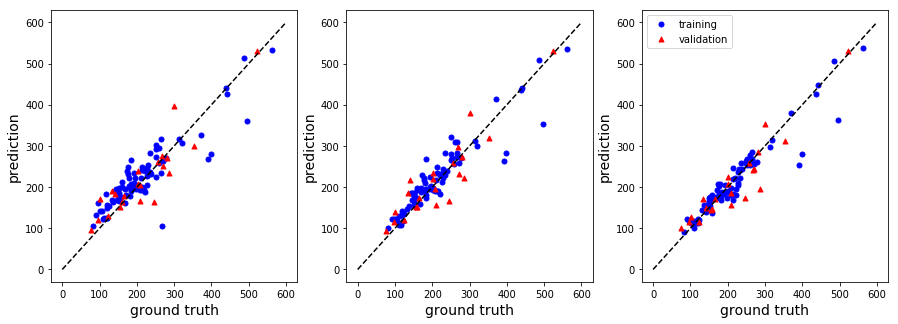

input first cycle, training set RMSE: 43.067; validation set RMSE: 40.631
input first 10 cycles, training set RMSE: 35.162; validation set RMSE: 40.067
input full 50 cycles, training set RMSE: 29.138; validation set RMSE: 35.017


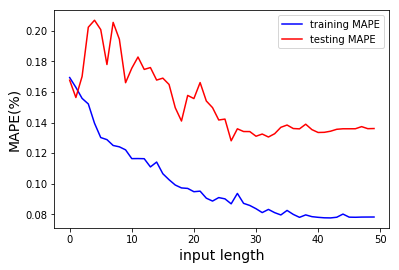

In [2]:
# evaluate the training data
model_path = 'checkpoint/checkpoint35.pth'
trn_input, trn_target = np.load('dataset/trn_features.npy'), np.load('dataset/trn_targets.npy')
val_input, val_target = np.load('dataset/val_features.npy'), np.load('dataset/val_targets.npy')
trn_input, val_input = trn_input/1.1, val_input/1.1 # nominal capacity

model = torch.load(model_path).cuda()
model.eval()
scaler_y = get_scaler()
trn_rmse, trn_mape, val_rmse, val_mape = [], [], [], []
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_index = 0
for n_cycle in range(50):
    trn_input_copy, val_input_copy = trn_input.copy(), val_input.copy()
    for i in range(len(trn_input)):
        trn_input_copy[i, :, n_cycle:] = trn_input_copy[i, :, n_cycle].reshape(-1, 1).repeat(50-n_cycle, axis=1)
    for i in range(len(val_input)):
        val_input_copy[i, :, n_cycle:] = val_input_copy[i, :, n_cycle].reshape(-1, 1).repeat(50-n_cycle, axis=1)
    with torch.no_grad():
        trn_pred = scaler_y.inverse_transform(model(torch.tensor(trn_input_copy).cuda().float()).detach().cpu().numpy())
        val_pred = scaler_y.inverse_transform(model(torch.tensor(val_input_copy).cuda().float()).detach().cpu().numpy())
    trn_rmse.append(np.sqrt(np.sum(np.square(trn_pred[:, 0]-trn_target))/len(trn_pred)))
    val_rmse.append(np.sqrt(np.sum(np.square(val_pred[:, 0]-val_target))/len(val_pred)))
    trn_mape.append(np.sum(np.abs(trn_pred[:, 0]-trn_target)/trn_target)/len(trn_pred))
    val_mape.append(np.sum(np.abs(val_pred[:, 0]-val_target)/val_target)/len(val_pred))
    
    if n_cycle in [0, 9, 49]:
        ax[plot_index].scatter(trn_target, trn_pred, c='blue', s=25, label='training')
        ax[plot_index].plot([0, 600], [0, 600], ls='--', c='black')
        ax[plot_index].scatter(val_target, val_pred, c='red', s=25, label='validation', marker='^')
        ax[plot_index].set_xlabel('ground truth', fontsize=14)
        ax[plot_index].set_ylabel('prediction', fontsize=14)
        plot_index += 1
# visualize training and validation set result
plt.legend()
plt.show()
plt.close()

print('input first cycle, training set RMSE: %.3f; validation set RMSE: %.3f' % (trn_rmse[0], val_rmse[0]))
print('input first 10 cycles, training set RMSE: %.3f; validation set RMSE: %.3f' % (trn_rmse[9], val_rmse[9]))
print('input full 50 cycles, training set RMSE: %.3f; validation set RMSE: %.3f' % (trn_rmse[49], val_rmse[49]))

# input cycle length vs RMSE
plt.plot(np.arange(50), trn_mape, c='blue', label='training MAPE')
plt.plot(np.arange(50), val_mape, c='red', label='testing MAPE')
plt.legend()
plt.xlabel('input length', fontsize=14)
plt.ylabel('MAPE(%)', fontsize=14)
plt.show()
plt.close()

the shape of raw features:  (19, 50, 1000, 2)


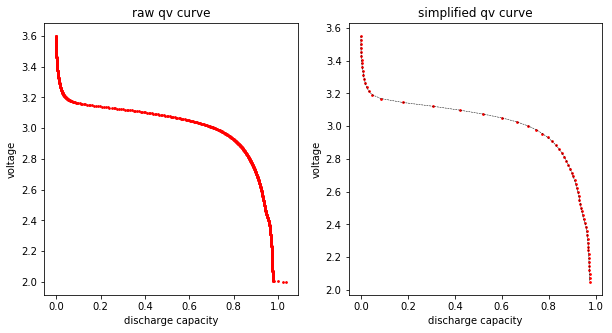

the shape of input array:  (19, 64, 50)
    Cell ID  Remaining Useful Life
0       108             209.437271
1       109             210.409241
2       110              96.958122
3       111             412.721710
4       112             184.513916
5       113             180.293793
6       114             143.362534
7       115             202.457870
8       116             134.084900
9       117             145.788986
10      118             217.719925
11      119             161.583023
12      120             228.184937
13      121             137.391342
14      122             200.275574
15      123             235.069992
16      124             162.874023
17      125             260.497620
18      126             167.675537


In [3]:
# testing data preprocessing and visualization
# load json file and transform into the numpy array: (n_samples, n_cycles, n_timesteps, n_features)
testing_set = json.load(open('dataset/test_data.json','r'))
for cell, values in testing_set.items():
    #Convert timeseries data JSON into a pandas dataframe for ease of use
    values["timeseries data"] = pd.read_json(values["timeseries data"])

features = []
for key in testing_set.keys():
    # extract qv curve
    features.append(testing_set[key]['timeseries data'].to_numpy()[:, [0, 2]].reshape(50, 1000, 2))

features = np.stack(features, axis=0).astype(np.float32)
print('the shape of raw features: ', features.shape) # (n_samples, n_cycles, n_timesteps, n_features)

# uniformly sample 64 points from the raw q-v curve based on the voltage value
testing_set = []
for cell_id in range(len(features)):
    curve = []
    for cycle in range(50):
        v = features[cell_id, cycle, :, 0]
        v = np.flip(np.sort(v))
        qd = features[cell_id, cycle, :, 1]
        qd = qd[np.flip(np.argsort(v))]
        interp_v, interp_qd = np.linspace(3.55, 2.05, 64), []
        v_pointer = 0
        for i in range(len(qd)):
            if v[i]<=interp_v[v_pointer]:
                interp_qd.append(qd[i])
                v_pointer += 1
                if v_pointer == 64:
                    break
                    
        if cell_id==0 and cycle==0:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
            ax[0].scatter(qd, v, c='red', s=3)
            ax[0].set_ylabel('voltage')
            ax[0].set_xlabel('discharge capacity')
            ax[0].set_title('raw qv curve')
            ax[1].plot(interp_qd, interp_v, c='black', ls='--', lw=0.5)
            ax[1].scatter(interp_qd, interp_v, c='red', s=3)
            ax[1].set_ylabel('voltage')
            ax[1].set_xlabel('discharge capacity')
            ax[1].set_title('simplified qv curve')
            plt.show()
            plt.close()
        curve.append(np.expand_dims(np.array(interp_qd), axis=1))
    testing_set.append(np.concatenate(curve, axis=1)) # (qv_ch, n_cycles=50)
testing_set = np.stack(testing_set, axis=0)/1.1
print('the shape of input array: ', testing_set.shape) # (n_samples, qv_ch, n_cycles)

# evaluate the testing data
model = torch.load(model_path).cuda()
model.eval()
scaler = get_scaler()
with torch.no_grad():
    test_pred = scaler.inverse_transform(model(torch.tensor(testing_set).cuda()).detach().cpu().numpy()).reshape(-1,)
df = pd.DataFrame({'Cell ID': np.linspace(108, 126, 19).astype(np.int32),
                   'Remaining Useful Life': test_pred})
print(df)
df.to_csv('test_result.csv', index=False)